# JAM FITTER

In [1]:
import copy
import sys, os
import fitpack
from fitlab.resman import RESMAN
from tools.config import load_config, conf
from tools.tools import load, save, checkdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
def lprint(msg):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % msg)
    sys.stdout.flush()

## setup

In [3]:
run_settings = {"dy": None,
                "prefix": None,
                "summary_dy": None,
                "config_dy": None,
                "sid_dy": None,
                "dat_thy_dy": None,
                "fig_seperation_dy": None,
                "fig_hermes_dy": None,
                "path2results": None}


def set_run_settings(dy, prefix, path2results=None):
    run_settings["dy"] = dy
    run_settings["prefix"] = prefix
    
    # inputs
    run_settings["summary_dy"] = '../samples/summary_alexei_dy'+prefix+'.mcp'
    run_settings["config_dy"] = '../inputs/upol_hermes_alexei'+prefix+'.py'

    # outputs
    run_settings["sid_dy"] = 'sidis.dat'
    run_settings["dat_thy_dy"] = 'data_and_thy.dat'
    run_settings["fig_seperation_dy"] = 'separation_alexei'+prefix+'.pdf'
    run_settings["fig_hermes_dy"] = 'hermes_fit_alexei'+prefix+'.pdf'
    
    if path2results is not None:
        checkdir(path2results)  # note: checkdir makes dir if needed
        run_settings["path2results"] = path2results

In [4]:
# set settings
set_run_settings(1.25, '125', path2results='sidis_torino')

In [5]:
# get fit data
runs = load(run_settings["summary_dy"])  # load reads pickled data

In [6]:
# set up conf
load_config(run_settings["config_dy"])
conf['resman'] = RESMAN(mode='solo', ip=None, nworkers=None)

loading sidis data sets 1007

### distribution of parameters

In [7]:
tab = {}
tab['nll'] = runs['all']['nll']
tab['weights'] = runs['all']['weights']
samples = np.transpose(runs['all']['samples'])
for i in range(len(conf['parman'].order)):
    _, kind, par = conf['parman'].order[i]
    tab['%s-%s' % (kind, par)] = samples[i]
tab = pd.DataFrame(tab)

In [8]:
print ", ".join(tab.columns)

ffk-widths1_fav, ffk-widths1_ufav, ffpi-widths1_fav, ffpi-widths1_ufav, gk-gk0, nll, pdf-widths1_sea, pdf-widths1_uv, weights


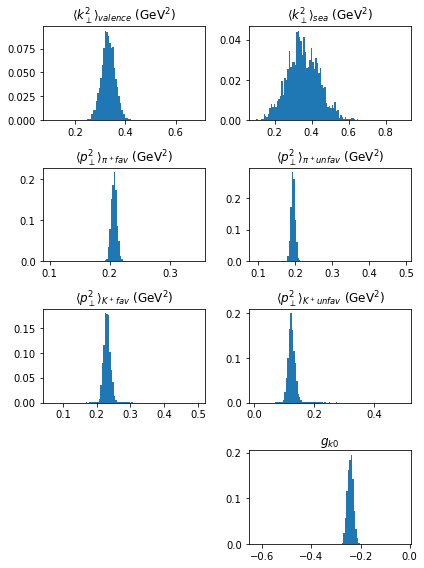

In [9]:
nrows, ncols = 4, 2
fig = plt.figure(figsize=(ncols * 3, nrows * 2))


def title(par, kind):
    if par == 'widths1_uv':
        return r"$\langle k_\perp^2 \rangle_{valence}$ (GeV$^2$)"
    if par == 'widths1_sea':
        return r"$\langle k_\perp^2 \rangle_{sea}$ (GeV$^2$)"
    if par == 'widths1_fav' and kind == "ffpi":
        return r"$\langle p_\perp^2 \rangle_{\pi^+ fav}$ (GeV$^2$)"
    if par == 'widths1_ufav'and kind == "ffpi":
        return r"$\langle p_\perp^2 \rangle_{\pi^+ unfav}$ (GeV$^2$)"
    if par == 'widths1_fav' and kind == "ffk":
        return r"$\langle p_\perp^2 \rangle_{K^+ fav}$ (GeV$^2$)"
    if par == 'widths1_ufav'and kind == "ffk":
        return r"$\langle p_\perp^2 \rangle_{K^+ unfav}$ (GeV$^2$)"
    if par == 'gk0':
        return r"$g_{k0}$"
    if par == 'Q0' and kind == "gk":
        return r"$Q_0$ (GeV$^2$)"


cnt = 0


def plot(tags):
    # TODO: switch to using 2-D tags list
    global cnt

    for i in range(len(tags)):
        cnt += 1

        if tags[i] == None:
            continue

        ax = plt.subplot(nrows, ncols, cnt)

        kind, par = tags[i].split('-')

        if kind == 'pdf':
            vmin = conf['params']['pdf'][par]['min']
            vmax = conf['params']['pdf'][par]['max']
            R = (vmin, vmax)
        elif kind == 'ffpi':
            vmin = conf['params']['ffpi'][par]['min']
            vmax = conf['params']['ffpi'][par]['max']
            R = (vmin, vmax)
        elif kind == 'ffk':
            vmin = conf['params']['ffk'][par]['min']
            vmax = conf['params']['ffk'][par]['max']
            R = (vmin, vmax)
        elif kind == 'sidis':
            vmin = conf['datasets']['sidis']['norm'][int(par)]['min']
            vmax = conf['datasets']['sidis']['norm'][int(par)]['max']
            R = (vmin, vmax)

        R = None  # XXX: why is R here?

        # for k in runs:
        #     ax.hist(runs[k]['samples'].T[idx],weights=runs[k]['weights'],bins=50,normed=True,range=R)
        # ax.hist(tab[tags[i]],normed=True)
        # tabk=tab.query('nll<1300')

        ax.hist(tab[tags[i]], range=R, bins=100, weights=tab['weights'])

        # ax.set_title(par)

        ax.set_title(title(par,kind))

        # print samples.T[idx]
        # print weights
        # ax.hist(samples2.T[idx],weights=weights2,bins=50,color='r',histtype='step',normed=True,range=R)
        # ax.set_title(tags[i])
        # ax.set_xlim(vmin,vmax)

    plt.tight_layout()


plot(['pdf-widths1_uv', 'pdf-widths1_sea'])
plot(['ffpi-widths1_fav', 'ffpi-widths1_ufav'])
plot(['ffk-widths1_fav', 'ffk-widths1_ufav'])
plot([None, 'gk-gk0'])

## data vs theory

In [10]:
data = {'weights': runs['all']['weights']}

count = 0
count_max = len(runs['all']['samples'])

_resman = conf['resman']

for s in runs['all']['samples']:
    count += 1
    lprint('%d/%d' % (count, count_max))

    _resman.get_residuals(s)

    for k, _tab in _resman.sidisres.tabs.items():
        if k  not in data:
            data[k] = []

        thy = _tab['thy']
        norm = conf['datasets']['sidis']['norm'][k]['value']
        shift = _tab['shift']

        data[k].append(shift + thy / norm)

save(data,'%s/%s' % (run_settings["path2results"], run_settings["sid_dy"]))

5009/5009

### compute averages and collect results

In [11]:
data=load('%s/%s'%(run_settings["path2results"], run_settings["sid_dy"]))   
for k in data: data[k]=np.array(data[k])
thy,dthy={},{}
for k in data:
    if k=='weights': continue
    thy[k]=np.einsum('i,ik->k',data['weights'],data[k])
    dthy[k]=np.einsum('i,ik->k',data['weights'],(data[k]-thy[k])**2)**0.5
for k in thy: 
    conf['resman'].sidisres.tabs[k]['thy']=copy.copy(thy[k])
    conf['resman'].sidisres.tabs[k]['dthy']=copy.copy(dthy[k])

In [12]:
report=conf['resman'].gen_report(verb=0,level=1)
delimiters=[]
for i in range(len(report)): 
    if 'reaction:' in report[i]: delimiters.append(i) 

data={}
nlines=len(report)
for i in range(len(delimiters)):
    ini=delimiters[i]
    if i==len(delimiters)-1: fin=len(report)
    else: fin=delimiters[i+1]
    reaction=report[ini].replace('reaction:','').strip()
    data[reaction]={'raw data':report[ini:fin]}
    
for k in data:
    print k
    block=data[k]['raw data']
    isep=[i for i in range(len(block)) if '--------' in block[i]][0]
    data[k]['summary']=[block[i] for i in range(isep)]
    data[k]['tables']=[block[i] for i in range(isep+1,len(block))]

    tabs={}
    for l in data[k]['tables']:
        info=l.split(',')
        col=[s for s in info if 'col' in s][0].split('=')[1].strip()
        if col not in tabs: tabs[col]={}
        info=[[ss.strip() for ss in s.split('=')] for s in info if 'col' not in info  if s.strip()!='']
        
        for s in info:
            if s[0] not in tabs[col]: tabs[col][s[0]]=[]
        
        for s in info:
            try:
                value=float(s[1])
            except:
                value=s[1]
            tabs[col][s[0]].append(value)        

    data[k]['tabs']=tabs
save(data,'%s/%s'%(run_settings["path2results"], run_settings["dat_thy_dy"]))  

sidis


In [13]:
def summary():
    for k in data:
        print ""
        for l in data[k]['summary']: print l
summary()


reaction: sidis
    idx        tar        had        col        obs  npts       chi2  chi2/npts      rchi2      nchi2
   1000     proton        pi+     hermes          M    45      87.59       1.95        0.00       0.00
   1001     proton        pi-     hermes          M    45      81.67       1.81        0.00       0.00
   1002     proton         k+     hermes          M    46      52.08       1.13        0.00       0.00
   1003     proton         k-     hermes          M    46      21.77       0.47        0.00       0.00
   1004   deuteron        pi+     hermes          M    45      59.33       1.32        0.00       0.00
   1005   deuteron        pi-     hermes          M    45      49.45       1.10        0.00       0.00
   1006   deuteron         k+     hermes          M    46      18.17       0.40        0.00       0.00
   1007   deuteron         k-     hermes          M    45      64.92       1.44        0.00       0.00


In [14]:
for k in data:
    for l in data[k]['summary']: print l

reaction: sidis
    idx        tar        had        col        obs  npts       chi2  chi2/npts      rchi2      nchi2
   1000     proton        pi+     hermes          M    45      87.59       1.95        0.00       0.00
   1001     proton        pi-     hermes          M    45      81.67       1.81        0.00       0.00
   1002     proton         k+     hermes          M    46      52.08       1.13        0.00       0.00
   1003     proton         k-     hermes          M    46      21.77       0.47        0.00       0.00
   1004   deuteron        pi+     hermes          M    45      59.33       1.32        0.00       0.00
   1005   deuteron        pi-     hermes          M    45      49.45       1.10        0.00       0.00
   1006   deuteron         k+     hermes          M    46      18.17       0.40        0.00       0.00
   1007   deuteron         k-     hermes          M    45      64.92       1.44        0.00       0.00


### Collect chi2, n points and draw distribution of parameters

In [15]:
for k in data:
    for l in data[k]['summary']: print(l)

reaction: sidis
    idx        tar        had        col        obs  npts       chi2  chi2/npts      rchi2      nchi2
   1000     proton        pi+     hermes          M    45      87.59       1.95        0.00       0.00
   1001     proton        pi-     hermes          M    45      81.67       1.81        0.00       0.00
   1002     proton         k+     hermes          M    46      52.08       1.13        0.00       0.00
   1003     proton         k-     hermes          M    46      21.77       0.47        0.00       0.00
   1004   deuteron        pi+     hermes          M    45      59.33       1.32        0.00       0.00
   1005   deuteron        pi-     hermes          M    45      49.45       1.10        0.00       0.00
   1006   deuteron         k+     hermes          M    46      18.17       0.40        0.00       0.00
   1007   deuteron         k-     hermes          M    45      64.92       1.44        0.00       0.00


In [16]:
def pointsall(data):
    npoints = 0
    for k in data:
        for l in data[k]['summary']:
            mydata = [token for token in l.split()]
            if len(mydata) > 6 and mydata[0].isdigit():
                npoints = npoints + float(mydata[5])
    return npoints

In [17]:
def chi2all(data):
    chi2 = 0
    for k in data:
        for l in data[k]['summary']:
            mydata = [token for token in l.split()]
            if len(mydata) > 6 and mydata[0].isdigit():
                chi2 = chi2 + float(mydata[6])
    return chi2           

In [18]:
chi2all(data)

434.98

In [19]:
pointsall(data)

363.0

In [20]:
np.mean(tab['pdf-widths1_uv'])
np.std(tab['pdf-widths1_sea'])

0.14638981989620803

C:\Users\mason\Anaconda3\envs\python2\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: The griddata function was deprecated in version 2.2. Use scipy.interpolate.griddata instead.
  app.launch_new_instance()


0.3324643922339456 0.026313437457178915


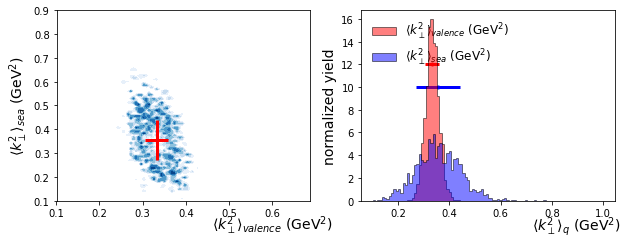

In [21]:
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
from matplotlib.mlab import griddata

nrows,ncols=1,2
plt.figure(figsize=(ncols*5,nrows*3.5))

samples2=runs['all']['samples']
weights2=runs['all']['weights']

ax=plt.subplot(121)

xgrid = np.linspace(np.amin(tab['pdf-widths1_uv']), np.amax(tab['pdf-widths1_uv']), 100)
ygrid = np.linspace(np.amin(tab['pdf-widths1_sea']), np.amax(tab['pdf-widths1_sea']), 100)
xgrid, ygrid = np.meshgrid(xgrid, ygrid)
zgrid = griddata(tab['pdf-widths1_uv'],tab['pdf-widths1_sea'],weights2, xgrid, ygrid,interp='linear')
zgrid/=np.amax(zgrid)
ax.contourf(xgrid, ygrid, zgrid,cmap=cm.Blues,levels=[0.15,0.3,0.45,0.6,0.75,0.9,1.05])

meanval=np.einsum('i,i',tab['pdf-widths1_uv'],weights2)
stdval=np.einsum('i,i',(tab['pdf-widths1_uv']-meanval)**2,weights2)**0.5

meansea=np.einsum('i,i',tab['pdf-widths1_sea'],weights2)
stdsea=np.einsum('i,i',(tab['pdf-widths1_sea']-meansea)**2,weights2)**0.5


ax.errorbar([meanval],[meansea],xerr=stdval,yerr=stdsea,fmt='r.',elinewidth=3,alpha=1.)
 
#ax.tick_params(axis='both', which='major', labelsize=18, direction='in')

ax.set_xlabel(r"$\langle k_\perp^2 \rangle_{valence}$ (GeV$^2$)",size=14)
ax.xaxis.set_label_coords(0.85, -0.07)

#ax.set_xlim(0.0,0.55)
#ax.set_xticks([0,0.1,0.2,0.3,0.4,0.5])
#ax.set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.2}$','',r'$\boldsymbol{0.4}$',''])

ax.set_ylabel(r"$\langle k_\perp^2 \rangle_{sea}$ (GeV$^2$)",size=14)

##############################################
ax=plt.subplot(122)

R=(0.1,1.)
bins=100

ax.hist(tab['pdf-widths1_uv'],histtype='stepfilled',range=R,weights=weights2,bins=bins,facecolor='r'\
   ,edgecolor='k'\
   ,label=r"$\langle k_\perp^2 \rangle_{valence}$ (GeV$^2$)",density=True,alpha=0.5,zorder=10);

ax.hist(tab['pdf-widths1_sea'],histtype='stepfilled',range=R,weights=weights2,bins=bins,facecolor='b'\
   ,edgecolor='k'\
   ,label=r"$\langle k_\perp^2 \rangle_{sea}$ (GeV$^2$)",density=True,alpha=0.5,zorder=10);

ax.errorbar([meansea],10,xerr=stdsea,yerr=0,fmt='b.',elinewidth=3,alpha=1.)

ax.errorbar([meanval],12,xerr=stdval,yerr=0,fmt='r.',elinewidth=3,alpha=1.)

meanfffav=np.einsum('i,i',tab['ffpi-widths1_fav'],weights2)
stdfffav=np.einsum('i,i',(tab['ffpi-widths1_fav']-meanfffav)**2,weights2)**0.5

meanffunfav=np.einsum('i,i',tab['ffpi-widths1_ufav'],weights2)
stdffunfav=np.einsum('i,i',(tab['ffpi-widths1_ufav']-meanffunfav)**2,weights2)**0.5

meanffkfav=np.einsum('i,i',tab['ffk-widths1_fav'],weights2)
stdffkfav=np.einsum('i,i',(tab['ffk-widths1_fav']-meanffkfav)**2,weights2)**0.5

meanffkunfav=np.einsum('i,i',tab['ffk-widths1_ufav'],weights2)
stdffkunfav=np.einsum('i,i',(tab['ffk-widths1_ufav']-meanffkunfav)**2,weights2)**0.5

meangk0=np.einsum('i,i',tab['gk-gk0'],weights2)
stdgk0=np.einsum('i,i',(tab['gk-gk0']-meangk0)**2,weights2)**0.5

#meanQ0=np.einsum('i,i',tab['gk-Q0'],weights2)
#stdQ0=np.einsum('i,i',(tab['gk-Q0']-meangk0)**2,weights2)**0.5

dy = run_settings["dy"]

descriptive_stat = [[dy,float(meanval), stdval], [dy,float(meansea), stdsea], [dy,float(meanfffav),stdfffav],
                    [dy,float(meanffunfav),stdffunfav], [dy,float(meanffkfav),stdffkfav],
                    [dy,float(meanffkunfav),stdffkunfav],[dy,float(meangk0),stdgk0]]

print meanval, stdval

#ax.tick_params(axis='both', which='major', labelsize=18, direction='in')

ax.set_xlabel(r"$\langle k_\perp^2 \rangle_{q}$ (GeV$^2$)",size=14)

#ax.set_xlim([0,1.5])
#ax.set_xticks([0,0.25,0.5,0.75,1,1.25])
#ax.set_xticklabels([r'$\boldsymbol{0}$','',r'$\boldsymbol{0.5}$','',r'$\boldsymbol{1}$',''])
ax.xaxis.set_label_coords(0.85, -0.07)

ax.set_ylabel(r'normalized yield',size=14)

#ax.set_ylim([0,7.5])
#ax.set_yticks([0,2,4,6])
#ax.set_yticklabels([r'$\boldsymbol{0}$',r'$\boldsymbol{2}$',r'$\boldsymbol{4}$',r'$\boldsymbol{6}$'])

ax.legend(frameon=False,fontsize=12,loc=2)

#ax.text(0.87,0.87,r'$\boldsymbol{\rm (b)}$',size=20,transform=ax.transAxes,color='k',alpha=1)

#plt.tight_layout()

plt.savefig("%s/%s" % (run_settings["path2results"], run_settings["fig_seperation_dy"]))

In [22]:
descriptive_stat

[[1.25, 0.3324643922339456, 0.026313437457178915],
 [1.25, 0.35479603955582495, 0.08488309075496529],
 [1.25, 0.2068866832448013, 0.004574206441323303],
 [1.25, 0.19424252107234805, 0.005568823166015191],
 [1.25, 0.23072259081464505, 0.009321674078203357],
 [1.25, 0.12435174112874937, 0.010858310155991558],
 [1.25, -0.24157622952290572, 0.011688431152194256]]

### plot data and theory

In [23]:
from matplotlib import rc
rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})

data = pd.concat(pd.DataFrame(d)
                 for d in conf["resman"].sidisres.tabs.values())

data = data[(data["hadron"] == "pi+") &
            (data["target"] == "proton")]

C:\Users\mason\Anaconda3\envs\python2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [24]:
#####################
# reading the data ##
#####################
#dat=pd.read_excel('E:/Laptop/School/Interships/Dr_Prokudin/Juniper82/PHYS296/dat/expdat/1000.xlsx');
#dat=pd.read_excel('C:/Users/Dolam/Documents/Scott/1000.xlsx');
dat=pd.read_excel('../database/sidis/expdata/1000.xlsx');

In [25]:
######################
# Calculated values ##
######################
dat["delta"] = np.sqrt(dat["stat_u"]**2.0) # measurment error

data["delta"] = np.sqrt(data["stat_u"]**2.0) # measurment error

In [26]:
##################
## Binning data ##
##################
# data bin edeges

xBin=np.array([0.023,0.047,0.075,0.12,0.35,0.6]) # Bins for x used to plot Pt
Q2Bin=np.array([1.0,10]) # **NOTE** includes all Q2 data, therefore all value data is plotted vs. Pt
zBin= np.array([0.1, 0.2,0.25,0.3, 0.375, 0.475, 0.6, 0.8, 1.1]) # catagories for z to be ploted indiviualy in each subplot

# binning data
dat['xBin'] = pd.cut(dat['x'], xBin,labels = False, retbins=0)
dat['Q2Bin'] = pd.cut(dat['Q2'], Q2Bin,labels = False, retbins=0)
dat['zBin'] = pd.cut(dat['z'], zBin,labels = False, retbins=0)

data['xBin'] = pd.cut(data['x'], xBin,labels = False, retbins=0)
data['Q2Bin'] = pd.cut(data['Q2'], Q2Bin,labels = False, retbins=0)
data['zBin'] = pd.cut(data['z'], zBin,labels = False, retbins=0)

# bins for x and y that have non-empty intersection
pTdatmod=[0,1,2,3,4] # xBins that overlap Q2Bins
valuedatmod=[0] # Q2bins that overlap xBins

C:\Users\mason\Anaconda3\envs\python2\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


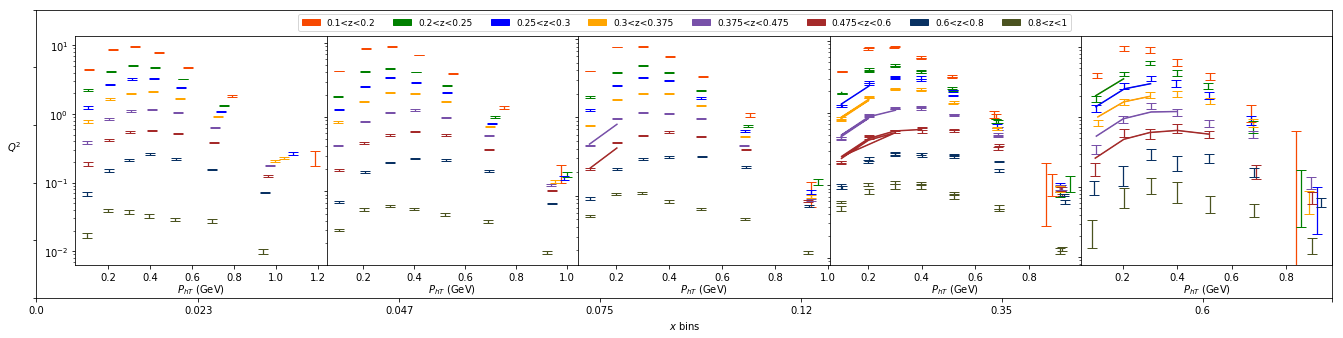

In [27]:
###############
# HermesPlot ##
###############  Reduced matix 
# initialize the figure
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages

fig1=plt.figure(figsize=(18, 4),facecolor="white") # figsize; wxh in inche
globalGrid=gridspec.GridSpec(1, 1,left=0.03,right=1,top=.91,bottom=.115, wspace=0.0, hspace=0.0) # plot for subplot matrix as 1x1 matrix
innerGrid=gridspec.GridSpecFromSubplotSpec(1,5 , subplot_spec=globalGrid[0], wspace=0.0, hspace=0.0) # 5x6 subplot grid 

# figure properties:
ax=fig1.add_axes([0,0,1,1]) # axas for subplot matrix as percent of hole
#ax.yaxis.set_ticks([0,1.25,2.76,4.27,5.78,7.29,8.8,10])
ax.xaxis.set_ticks([0,1.25,2.8,4.35,5.9,7.45,9,10 ])
xticklabels = np.array([0,0.023,0.047,0.075,0.12,0.35,0.6]) 

ax.set_yticklabels("")
ax.set_xticklabels(xticklabels)
ax.set_xlabel(r"$x$ bins") # xy-lables
ax.set_ylabel(r"$Q^2$",rotation="horizontal",labelpad = 15)
#ax.grid() # grid currently off

# subplot axis proerties (unused)
Zcolor=['#F74902',"green","blue",'orange',"#7851a9","brown",'#093162','#4b5320']
Zmark=["o","o","o","o"]

# Set legend
Zpatch1 = mpatches.Patch(color=Zcolor[0], label='0.1<z<0.2')
Zpatch2 = mpatches.Patch(color=Zcolor[1], label='0.2<z<0.25')
Zpatch3 = mpatches.Patch(color=Zcolor[2], label='0.25<z<0.3')
Zpatch4 = mpatches.Patch(color=Zcolor[3], label='0.3<z<0.375')
Zpatch5 = mpatches.Patch(color=Zcolor[4], label='0.375<z<0.475')
Zpatch6 = mpatches.Patch(color=Zcolor[5], label='0.475<z<0.6')
Zpatch7 = mpatches.Patch(color=Zcolor[6], label='0.6<z<0.8')
Zpatch8 = mpatches.Patch(color=Zcolor[7], label='0.8<z<1')
          
ax.legend(handles=[Zpatch1,Zpatch2,Zpatch3,Zpatch4,Zpatch5,Zpatch6,Zpatch7,Zpatch8],
          loc='upper center',
          ncol=8,prop={'size': 9}
          )
          
for f,F in zip(range(len(pTdatmod)),pTdatmod):       
    for j,J in zip(range(len(valuedatmod)),valuedatmod):
        
        k = int(f) # kth possition for subplot on innerGrid matrix
        maskX = dat['xBin'].isin([F]) # returns boolean for all Jth xBin in dat  
        maskY = dat['Q2Bin'].isin([J]) # returns boolean for all Fth Q2Bin in dat
        
        maskX_thr = data['xBin'].isin([F]) # returns boolean for all Jth xBin in dat  
        maskY_thr = data['Q2Bin'].isin([J]) # returns boolean for all Fth Q2Bin in dat
       
        ax = fig1.add_subplot(innerGrid[k]) # add subplot in innerGrid
        xydat = dat[maskX & maskY] # subset of data for Jth xBin and Fth Q2Bin
        
        xydata = data[maskX_thr & maskY_thr] # subset of data for Jth xBin and Fth Q2Bin
        
        for z in range(len(zBin)-1): 
            maskZ = xydat["zBin"].isin([z])
            databin = xydat[maskZ]
            
            maskZ_thr = xydata["zBin"].isin([z])
            databin_thr = xydata[maskZ_thr]
            
            if f != 0:
                ax.errorbar(databin['pT'],databin['value'],yerr=databin['delta'],capsize=5,linestyle="",color = Zcolor[z],elinewidth=1.25)
                ax.set_xlabel(r"$p_T$ (GeV)",labelpad=1)
                ax.set_yscale('log')
                ax.set_yticklabels('')
                
                ax.plot(databin_thr['pT'],databin_thr['thy'],linestyle="-",color = Zcolor[z]) # theory
                ax.fill_between(databin_thr['pT'],databin_thr['thy']-databin_thr['dthy'],databin_thr['thy']+databin_thr['dthy']) # theory error
                ax.set_xlabel(r"$P_{hT}$ (GeV)",labelpad=1)
                ax.set_yticklabels('')
               
            else:
                ax.errorbar(databin['pT'],databin['value'],yerr=databin['delta'],capsize=5,linestyle="", color = Zcolor[z],elinewidth=1.25)
                
                ax.plot(databin_thr['pT'],databin_thr['thy'],linestyle="-",color = Zcolor[z]) #theory
                ax.fill_between(databin_thr['pT'],databin_thr['thy']-databin_thr['dthy'],databin_thr['thy']+databin_thr['dthy']) # theory error

                
                ax.set_xlabel(r"$P_{hT}$ (GeV)",labelpad=1)
                ax.set_yscale('log')
plt.savefig("%s/%s" % (run_settings["path2results"], run_settings["fig_hermes_dy"]))             

## writing descriptive stats

In [28]:
import pickle
path2stat='sidis_hermes_torino_alexei_dy'
checkdir(path2stat)

dictionary = {'val':descriptive_stat[0], 'sea':descriptive_stat[1],'fav': descriptive_stat[2], 
               'unfav': descriptive_stat[3],'kfav':descriptive_stat[4],'kunfav':descriptive_stat[5],
              'gk0':descriptive_stat[6]}

with open(path2stat + '/descriptive_alexei_dy' + run_settings["prefix"] + '.pkl', "wb") as f:
    pickle.dump(dictionary, f)